In [1]:
#Importar las librerías necesarias
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from IPython.display import display_html
from scipy import stats
from scipy.stats import norm
import datetime as dt

# 1. ABRIR EL ARCHIVO DE DATOS Y LEER LA INFORMACIÓN GENERAL

In [2]:
#Leer las tablas originales
raw_logs = pd.read_csv('datasets/logs_exp_us.csv', sep='\t')

In [3]:
#Crear función para primer vistazo de los datos
def first_lookup (dataframe):
    print('-----Dataframe information-----')
    display(dataframe.info())
    print('\n-----Statistics-----\n')
    display(dataframe.describe())
    print('\n-----Duplicates-----\n')
    print(dataframe.duplicated().sum())
    print('\n-----Empty values-----\n')
    print(dataframe.isna().sum())
    print('\n-----Head rows-----\n')
    display(dataframe.head(10))    

In [4]:
#Llamada a la función para primer vistazo de la tabla de hipótesis
first_lookup(raw_logs)

-----Dataframe information-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None


-----Statistics-----



,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000



-----Duplicates-----

413

-----Empty values-----

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

-----Head rows-----



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


# 2. PREPARAR LOS DATOS PARA EL ANÁLISIS

In [5]:
#Crear copias de las tablas originales
clean_logs = raw_logs.copy()

In [6]:
#Limpiar nombres de las columnas de todas las tablas
clean_logs.columns = [columna.lower().replace(' ','_') for columna in clean_logs.columns]

In [7]:
#Cambiar tipo de datos a las columnas donde aplique
clean_logs['deviceidhash'].astype('string')
clean_logs['expid'].astype('string')
# clean_logs['eventtimestamp'].pd.to_numeric(clean_logs['eventtimestamp'])

clean_logs['eventtimestamp'] = pd.to_datetime(clean_logs['eventtimestamp'],unit='s')

#Agregar columna de fecha
clean_logs['date'] = clean_logs['eventtimestamp'].dt.date

In [8]:
display(clean_logs)

,eventname,deviceidhash,eventtimestamp,expid,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [9]:
#Buscar valores ausentes y registros duplicados
print(f'Valores ausentes {clean_logs.isna().sum()}\n')
print(f'Registros duplicados {clean_logs.duplicated().sum()}')

Valores ausentes eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
date              0
dtype: int64

Registros duplicados 413


In [10]:
#Eliminar registros duplicados
clean_logs = clean_logs.drop_duplicates().reset_index(drop=True)
print(f'Registros duplicados {clean_logs.duplicated().sum()}')

Registros duplicados 0


In [11]:
#Buscar duplicados de deviceidhash y eventtimestamp que pudieran aparecer en ambos grupos
duplicated_devices = clean_logs.groupby('deviceidhash')['expid'].nunique().reset_index()
display(duplicated_devices.query('expid>1'))
duplicated_events = clean_logs.groupby('eventtimestamp')['expid'].nunique().reset_index()
display(duplicated_events.query('expid>1'))

,deviceidhash,expid


,eventtimestamp,expid
224,2019-07-29 11:30:15,2
952,2019-07-31 09:58:31,2
983,2019-07-31 10:17:22,2
1013,2019-07-31 10:40:25,2
1028,2019-07-31 10:46:37,2
...,...,...
176499,2019-08-07 20:50:43,2
176526,2019-08-07 20:53:30,2
176544,2019-08-07 20:55:23,2
176558,2019-08-07 20:56:53,2


### NOTA
+ Los eventos duplicados corresponden a los grupos de control A/A

# 3. ESTUDIAR Y COMPROBAR LOS DATOS

## 3.1 ¿Cuántos eventos hay en los registros?

In [12]:
print(clean_logs['eventname'].unique().tolist())
print(f'Número de eventos únicos {clean_logs['eventname'].nunique()}')
print(f'Número de eventos registrados {clean_logs['eventname'].count()}')

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Número de eventos únicos 5
Número de eventos registrados 243713


## 3.2 ¿Cuántos usuarios hay en los registros?

In [13]:
total_users = clean_logs['deviceidhash'].nunique()
print(f' Número de usuarios únicos {total_users}')

 Número de usuarios únicos 7551


## 3.3 ¿Cuál es el promedio de eventos por usuario?

In [14]:
print(f'Promedio de eventos por usuario {clean_logs['eventname'].count() / clean_logs['deviceidhash'].nunique()}')

Promedio de eventos por usuario 32.27559263673685


## 3.4 ¿Qué periodo de tiempo cubren los datos?

Fecha mínima 2019-07-25 04:43:36
Fecha máxima 2019-08-07 21:15:17


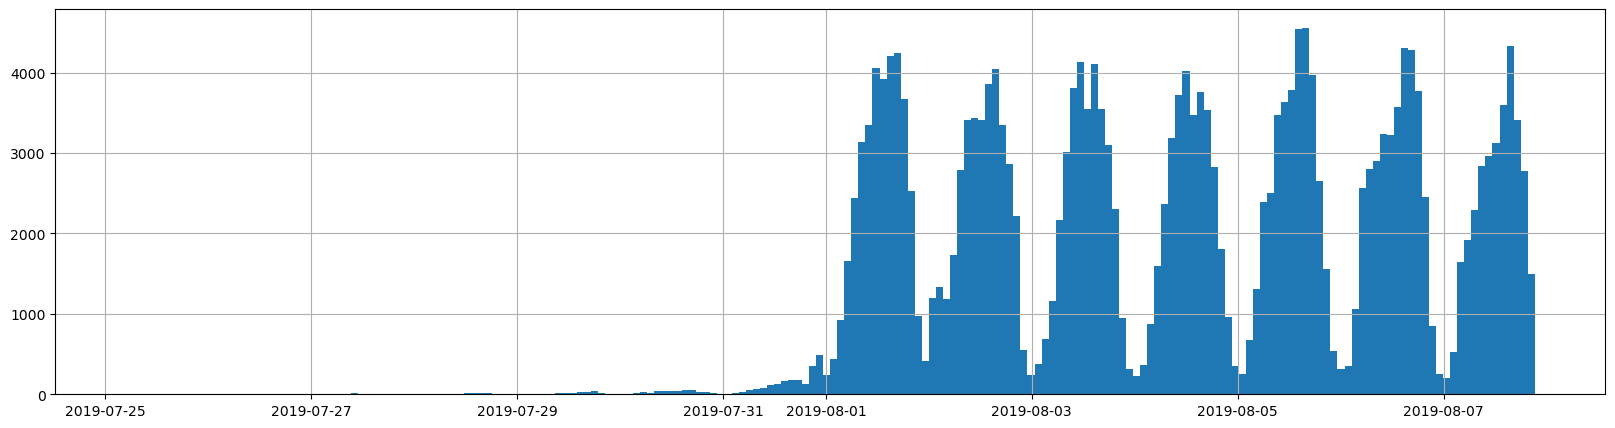

In [15]:
#Encontrar fecha mínima y máxima y trazar histograma
print(f'Fecha mínima {clean_logs['eventtimestamp'].min()}')
print(f'Fecha máxima {clean_logs['eventtimestamp'].max()}')
plt.figure(figsize=(20,5))
clean_logs['eventtimestamp'].hist(bins=200)
plt.show()

### NOTAS
+ Existen registros desde el 25 de julio de 2019, sin embargo, el histograma muestra una actividad mayoritaria a partis del 1 de agosto de 2019.
+ Para este análisis voy a tomar los datos a partir del 1 de agosto de 2019

In [16]:
#Contar el número de registros que existen antes del 1 de agosto de 2019
print(clean_logs.query('eventtimestamp<"2019-08-01"').count())
#Obtener el porcentaje de registros que se borrarían
(clean_logs.query('eventtimestamp<"2019-08-01"').count()/clean_logs.count() * 100).round(2)

eventname         2826
deviceidhash      2826
eventtimestamp    2826
expid             2826
date              2826
dtype: int64


eventname         1.16
deviceidhash      1.16
eventtimestamp    1.16
expid             1.16
date              1.16
dtype: float64

### NOTA
+ Los registros que existen antes del 1 de agosto de 2019 representan únicamente el 1.16% del total de los datos
  

In [17]:
#Eliminar registros de antes del 1 de agosto de 2019
clean_logs = clean_logs.query('eventtimestamp >= "2019-08-01"').reset_index()
display(clean_logs)

,index,eventname,deviceidhash,eventtimestamp,expid,date
0,2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...,...
240882,243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
240883,243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
240884,243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
240885,243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


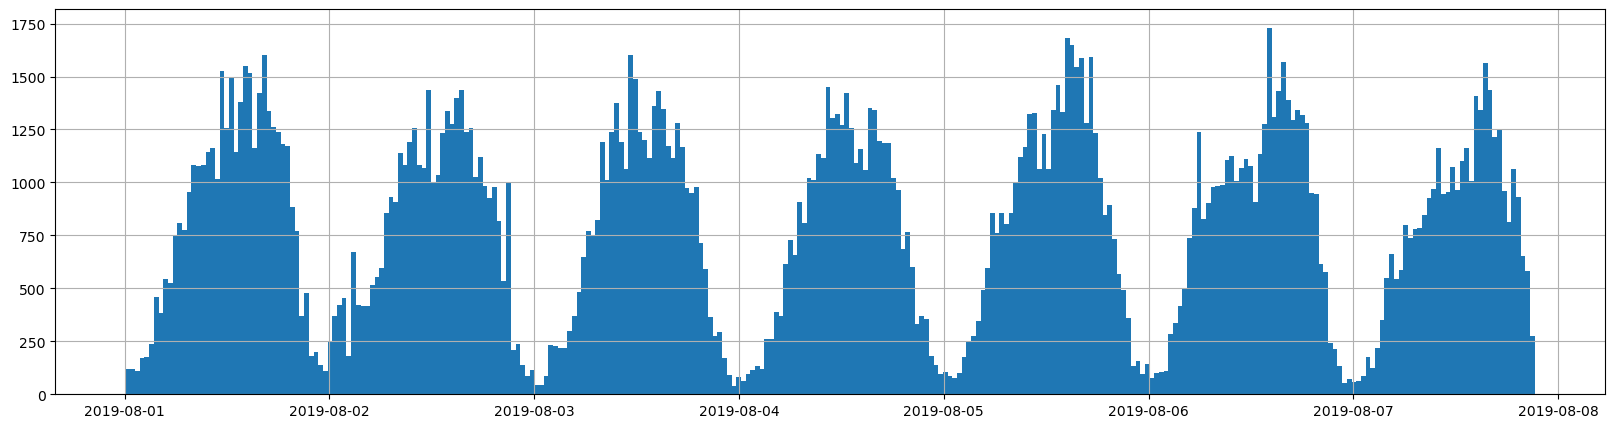

In [18]:
plt.figure(figsize=(20,5))
clean_logs['eventtimestamp'].hist(bins=300)
plt.show()

In [19]:
clean_logs['expid'].unique()

array([246, 247, 248], dtype=int64)

# 4. ESTUDIAR EL EMBUDO DE EVENTOS

## 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [20]:
#Encontrar los eventos únicos
clean_logs['eventname'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [21]:
#Agrupar por eventos únicos y contar el número de eventos
events_frequency = clean_logs.groupby('eventname').agg({'eventname':'count'})
events_frequency.columns = ['frequency']
events_frequency.sort_values(by='frequency',ascending=False)

,frequency
eventname,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


## 4.2 Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez

In [22]:
#Agrupar por eventos y contar el número de usuarios
users_per_event = clean_logs.groupby('eventname').agg({'deviceidhash':'nunique'}).sort_values(by='deviceidhash',ascending=False)
display(users_per_event)

,deviceidhash
eventname,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [23]:
#Calcular la proporción de usuarios por evento contra el total de usuarios
users_per_event['users_ratio %'] = users_per_event['deviceidhash'] / total_users * 100
display(users_per_event)

,deviceidhash,users_ratio %
eventname,,
MainScreenAppear,7419,98.251887
OffersScreenAppear,4593,60.826381
CartScreenAppear,3734,49.450404
PaymentScreenSuccessful,3539,46.867965
Tutorial,840,11.124354


## 4.3 ¿En qué orden crees que ocurrieron las aciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

La secuencia que siguen los usuarios está en el orden en que aparece en la tabla anterior, excepto por el evento Tutorial, que no necesariamente forma parte de la secuencia principal, ya que habrá usuarios que sigan no sigan el tutorial, y aún así terminen comprando algo.ncipal.

## 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [24]:
#Calcular proporciones entre eventos del embudo
users_per_event['funnel_ratio %'] = (users_per_event['deviceidhash'] / users_per_event['deviceidhash'].shift()) * 100
display(users_per_event)

,deviceidhash,users_ratio %,funnel_ratio %
eventname,,,
MainScreenAppear,7419,98.251887,NaN
OffersScreenAppear,4593,60.826381,61.908613
CartScreenAppear,3734,49.450404,81.297627
PaymentScreenSuccessful,3539,46.867965,94.777718
Tutorial,840,11.124354,23.735519


## 4.5 ¿En qué etapa pierdes más usuarios?

+ Para esta pregunta no tomo en cuenta la etapa de tutorial ni el ratio calculado.
+ Desde la pantalla de inicio a la pantalla de ofertas sólo llegan el 61.9% de los usuarios. Es la transición con menos ratio de conversión.

## 4.6 ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [25]:
#Calcular la proporción entre usuarios de Main Screen contra Payment Screen
full_funnel = users_per_event.copy()
display(full_funnel)
full_ratio = (full_funnel.loc['PaymentScreenSuccessful', 'deviceidhash'] / full_funnel.loc['MainScreenAppear', 'deviceidhash'] * 100).round(2)
print(f'El {full_ratio} % de los usuarios que llegan al Main Screen terminan en la Payment Screen')

,deviceidhash,users_ratio %,funnel_ratio %
eventname,,,
MainScreenAppear,7419,98.251887,NaN
OffersScreenAppear,4593,60.826381,61.908613
CartScreenAppear,3734,49.450404,81.297627
PaymentScreenSuccessful,3539,46.867965,94.777718
Tutorial,840,11.124354,23.735519


El 47.7 % de los usuarios que llegan al Main Screen terminan en la Payment Screen


# 5. ESTUDIAR LOS RESULTADOS DEL EXPERIMENTO

## 5.1 ¿Cuántos usuarios hay en cada grupo?

In [26]:
#Agrupar por número de experimento y contar la cantidad de usuarios únicos en cada uno
users_per_group = clean_logs.groupby('expid').agg({'deviceidhash':'nunique'})
display(users_per_group)

,deviceidhash
expid,
246,2484
247,2513
248,2537


## 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

#### Utilizo el estadístico Z para comprobar la diferencia entre las proporciones de usuarios que llegan a la pantalla de pago en cada grupo. Si la diferencia no es estadsíticamente significativa, podemos afirmar que ambos grupos cumplen las mismas condiciones de prueba.

In [27]:
#Crear dataframes para cada grupo de prueba
exp_246 = clean_logs[clean_logs['expid'] == 246]
exp_247 = clean_logs[clean_logs['expid'] == 247]

#Calcular el número de usuarios únicos que llegan a la pantalla de pago en ambos grupos
success_screen_246 = (exp_246[exp_246['eventname'] == 'PaymentScreenSuccessful'])['deviceidhash'].nunique()
success_screen_247 = (exp_247[exp_247['eventname'] == 'PaymentScreenSuccessful'])['deviceidhash'].nunique()

#Encontrar el número total de usuarios únicos en cada grupo
total_users_246 = exp_246['deviceidhash'].nunique()
total_users_247 = exp_247['deviceidhash'].nunique()

print(f'Total de usuarios en el grupo 246: {total_users_246}')
print(f'Total de usuarios que llegan a la pantalla de pago en el grupo 246: {success_screen_246}')

print(f'Total de usuarios en el grupo 247: {total_users_247}')
print(f'Total de usuarios que llegan a la pantalla de pago en el grupo 247: {success_screen_247}')

Total de usuarios en el grupo 246: 2484
Total de usuarios que llegan a la pantalla de pago en el grupo 246: 1200
Total de usuarios en el grupo 247: 2513
Total de usuarios que llegan a la pantalla de pago en el grupo 247: 1158


In [28]:
#Establecer el nivel de significación alpha y calcular las proporciones de éxito para ambos grupos
alpha = 0.05

p246 = success_screen_246/total_users_246
p247 = success_screen_247/total_users_247

#Calcular la proporción combinada
p_combined = (success_screen_246 + success_screen_247) / (total_users_246 + total_users_247)

#Calcular la diferencia entre proporciones
difference = p246 - p247

#Calcular el error estándar
std_error = np.sqrt(p_combined * (1 - p_combined) * (1/total_users_246 + 1/total_users_247))

#Calcular es estadístico Z
z_value = difference / std_error

distr = st.norm(0,1)

#Calcular el valor p bilateral
p_value = 2 * (1 - distr.cdf(abs(z_value)))

In [29]:
if p_value < alpha:
    print('Se rechaza la hipótesis nula: Existe una diferencia estadísticamente significativa entre las muestras de los grupos 246 y 247.')
else:
    print('No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que las muestras 246 y 247 son significativamente diferentes.')

No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que las muestras 246 y 247 son significativamente diferentes.


### NOTA
+ El cálculo del estadístico Z nos permitió determinar que las muestras de los grupos 246 y 247 son estadísticamente iguales y con ello podemos afirmar que las pruebas A/A se comportan de manera similar en los grupos de control

## 5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [30]:
#Encontrar el evento más popular
high_rate_event = clean_logs.groupby('eventname')['deviceidhash'].nunique().idxmax()
print(f"Evento más popular: {high_rate_event}")

Evento más popular: MainScreenAppear


In [31]:
#Definir la función para calcular verificar las diferencias estadísticas entre grupos
def z_value_test(dataframe, event, group1, group2, alpha=0.05):
       
    # Crear un dataframe para cada grupo
    df_group1 = dataframe[dataframe['expid'] == group1]
    df_group2 = dataframe[dataframe['expid'] == group2]
    
    # Calcular éxitos y totales por grupo
    success1 = df_group1[df_group1['eventname'] == event]['deviceidhash'].nunique()
    success2 = df_group2[df_group2['eventname'] == event]['deviceidhash'].nunique()
    total1 = df_group1['deviceidhash'].nunique()
    total2 = df_group2['deviceidhash'].nunique()
    
    # Calcular proporciones
    p1 = success1 / total1
    p2 = success2 / total2
    
    # Proporción combinada
    p_combined = (success1 + success2) / (total1 + total2)
    
    # Error estándar
    std_error = np.sqrt(p_combined * (1 - p_combined) * (1 / total1 + 1 / total2))
    
    # Estadístico Z
    z_value = (p1 - p2) / std_error
    
    # p-valor (bilateral)
    p_value = 2 * (1 - norm.cdf(abs(z_value)))
    
    # Resultados
    print(f"\nEvento: {event}")
    print(f"Grupo {group1}: Éxitos = {success1}, Total = {total1}, Proporción = {p1:.4f}")
    print(f"Grupo {group2}: Éxitos = {success2}, Total = {total2}, Proporción = {p2:.4f}")
    print(f"Diferencia entre proporciones: {p1 - p2:.4f}")
    print(f"Estadístico Z: {z_value:.4f}")
    print(f"Valor P: {p_value:.4f}")
    
    # Conclusión
    if p_value < alpha:
        print("Rechazamos la hipótesis nula: Existe una diferencia estadísticamente significativa entre los grupos.")
    else:
        print("No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que los grupos son significativamente diferentes.")

In [32]:
#Calcular el estadístico Z para el evento más popular
# Paso 3: Aplicar la prueba al evento más popular
z_value_test(clean_logs, high_rate_event, 246, 247)


Evento: MainScreenAppear
Grupo 246: Éxitos = 2450, Total = 2484, Proporción = 0.9863
Grupo 247: Éxitos = 2476, Total = 2513, Proporción = 0.9853
Diferencia entre proporciones: 0.0010
Estadístico Z: 0.3093
Valor P: 0.7571
No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que los grupos son significativamente diferentes.


In [33]:
#Aplicar la función de cálculo del estadístico Z a los demás eventos
unique_events = clean_logs['eventname'].unique()
for event in unique_events:
    z_value_test(clean_logs, event, 246, 247)


Evento: Tutorial
Grupo 246: Éxitos = 278, Total = 2484, Proporción = 0.1119
Grupo 247: Éxitos = 283, Total = 2513, Proporción = 0.1126
Diferencia entre proporciones: -0.0007
Estadístico Z: -0.0782
Valor P: 0.9377
No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que los grupos son significativamente diferentes.

Evento: MainScreenAppear
Grupo 246: Éxitos = 2450, Total = 2484, Proporción = 0.9863
Grupo 247: Éxitos = 2476, Total = 2513, Proporción = 0.9853
Diferencia entre proporciones: 0.0010
Estadístico Z: 0.3093
Valor P: 0.7571
No se puede rechazar la hipótesis nula: No hay suficiente evidencia estadística para concluir que los grupos son significativamente diferentes.

Evento: OffersScreenAppear
Grupo 246: Éxitos = 1542, Total = 2484, Proporción = 0.6208
Grupo 247: Éxitos = 1520, Total = 2513, Proporción = 0.6049
Diferencia entre proporciones: 0.0159
Estadístico Z: 1.1550
Valor P: 0.2481
No se puede rechazar la hipótesis nula: No hay sufic

## 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

In [34]:
# Crear el grupo combinado de control
control_groups = clean_logs[clean_logs['expid'].isin([246, 247])]

# Función extendida para comparar con varios grupos
def extended_z_value_test(data, event, group1, group2, group1_name, group2_name, alpha=0.05):
    """
    Realiza la prueba de diferencia de proporciones entre dos grupos para un event específico.
    """
    # Filtrar los datos por los grupos
    if group2 == "control_combinado":  # Manejo especial para el grupo combinado
        df_group1 = data[data['expid'] == group1]
        df_group2 = control_groups
    else:
        df_group1 = data[data['expid'] == group1]
        df_group2 = data[data['expid'] == group2]
    
    # Calcular éxitos y totales por grupo
    success1 = df_group1[df_group1['eventname'] == event]['deviceidhash'].nunique()
    success2 = df_group2[df_group2['eventname'] == event]['deviceidhash'].nunique()
    total1 = df_group1['deviceidhash'].nunique()
    total2 = df_group2['deviceidhash'].nunique()
    
    # Verificar que los totales no sean cero
    if total1 == 0 or total2 == 0:
        print(f"\nevent: {event}")
        print(f"No hay datos suficientes en {group1_name} o {group2_name}.")
        print(f"{group1_name}: Total usuarios = {total1}")
        print(f"{group2_name}: Total usuarios = {total2}")
        return  # Salir de la función para este event
    
    # Calcular proporciones
    p1 = success1 / total1
    p2 = success2 / total2
    
    # Proporción combinada
    p_combined = (success1 + success2) / (total1 + total2)
    
    # Error estándar
    std_error = np.sqrt(p_combined * (1 - p_combined) * (1 / total1 + 1 / total2))
    
    # Estadístico Z
    z_value = (p1 - p2) / std_error
    
    # p-valor (bilateral)
    p_value = 2 * (1 - norm.cdf(abs(z_value)))
    
    # Resultados
    print(f"\nComparación: {group1_name} vs {group2_name}")
    print(f"event: {event}")
    print(f"{group1_name}: Éxitos = {success1}, Total = {total1}, Proporción = {p1:.4f}")
    print(f"{group2_name}: Éxitos = {success2}, Total = {total2}, Proporción = {p2:.4f}")
    print(f"Diferencia entre proporciones: {p1 - p2:.4f}")
    print(f"Estadístico Z: {z_value:.4f}")
    print(f"P-valor: {p_value:.4f}")
    
    # Conclusión
    if p_value < alpha:
        print("Rechazamos la hipótesis nula: Existe una diferencia estadísticamente significativa.")
    else:
        print("No rechazamos la hipótesis nula: No hay suficiente evidencia estadística para concluir que hay diferencias significativas.")

# Iterar por cada event y comparar los grupos
unique_events = clean_logs['eventname'].unique()

print("\n--- Comparaciones para el grupo con fuentes alteradas (248) ---")
for event in unique_events:
    # Comparar 248 vs 246
    extended_z_value_test(clean_logs, event, 248, 246, "Grupo 248", "Grupo 246")
    # Comparar 248 vs 247
    extended_z_value_test(clean_logs, event, 248, 247, "Grupo 248", "Grupo 247")
    # Comparar 248 vs grupo combinado (246 + 247)
    extended_z_value_test(clean_logs, event, 248, "control_combinado", "Grupo 248", "Control Combinado", alpha=0.05)


--- Comparaciones para el grupo con fuentes alteradas (248) ---

Comparación: Grupo 248 vs Grupo 246
event: Tutorial
Grupo 248: Éxitos = 279, Total = 2537, Proporción = 0.1100
Grupo 246: Éxitos = 278, Total = 2484, Proporción = 0.1119
Diferencia entre proporciones: -0.0019
Estadístico Z: -0.2193
P-valor: 0.8264
No rechazamos la hipótesis nula: No hay suficiente evidencia estadística para concluir que hay diferencias significativas.

Comparación: Grupo 248 vs Grupo 247
event: Tutorial
Grupo 248: Éxitos = 279, Total = 2537, Proporción = 0.1100
Grupo 247: Éxitos = 283, Total = 2513, Proporción = 0.1126
Diferencia entre proporciones: -0.0026
Estadístico Z: -0.2985
P-valor: 0.7653
No rechazamos la hipótesis nula: No hay suficiente evidencia estadística para concluir que hay diferencias significativas.

Comparación: Grupo 248 vs Control Combinado
event: Tutorial
Grupo 248: Éxitos = 279, Total = 2537, Proporción = 0.1100
Control Combinado: Éxitos = 561, Total = 4997, Proporción = 0.1123
Dife

## 5.5 ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

   
1. Nivel de significancia establecido\
En todas las pruebas de hipótesis, el nivel de significancia α (alfa) utilizado fue 0.05 (5%). Esto significa que hay un 5% de probabilidad de cometer un error tipo I (rechazar la hipótesis nula cuando es verdadera).

2. Cantidad de pruebas de hipótesis realizadas\
   Se realizaron 15 pruebas de hipótesis con comparación de proporciones entre grupos. Estas incluyen:
    + Comparaciones entre Grupo 246 y Grupo 247.
    + Comparaciones entre Grupo 248 y los grupos de control (246 y 247).
    + Comparaciones entre Grupo 248 y el grupo combinado de control (246 + 247).

   Cada prueba se hizo para los siguientes eventos:
    + MainScreenAppear
    + OffersScreenAppear
    + CartScreenAppear
    + PaymentScreenSuccessful
    + Tutorial

    Dado que cada comparación se hizo entre distintos grupos, el número total de pruebas es:\
    3 (comparaciones) × 5 (eventos) = 15 pruebas

3. Interpretación del nivel de significancia y falsos positivos\
Con un nivel de significancia de 0.1 (10%), se esperaría que 1 de cada 10 pruebas arroje un falso positivo. Si mantenemos 15 pruebas, podríamos esperar alrededor de 1.5 pruebas con falsos positivos en promedio. El nivel de significancia óptimo depende del riesgo que estemos dispuestos a aceptar. Si queremos minimizar los falsos positivos, podríamos reducir α(alfa) a 0.01 (1%), pero esto también aumenta el riesgo de error tipo II (no detectar una diferencia real cuando sí existe).

4. ¿Cuál debería ser el nivel de significancia?
Dado que el análisis no se encontró diferencias significativas en las pruebas ( p>0.05 en todos los casos), cambiar el nivel de significancia no afectará las conclusiones. Si queremos asegurarnos de que las diferencias sean realmente significativas, podemos reducir α a 0.01 (1%), pero en este caso, ya que no hubo diferencias estadísticamente significativas con α = 0.05 tampoco las habría con α=0.01.

5. Conclusiones del análisis\
+ No se encontraron diferencias estadísticamente significativas entre los grupos (p-valor > 0.05 en todas las pruebas).
+ El evento con mayor pérdida de usuarios es "MainScreenAppear", con un 38% de abandono.
+ El 47.81% de los usuarios completan el embudo de compra hasta el pago. Las muestras de los grupos 246 y 247 parecen haber sido bien divididas, ya que no se encontraron diferencias significativas.
+ El grupo 248 (con fuentes alteradas) tampoco mostró diferencias significativas respecto a los grupos de control.
+ Recomendaciones Si deseas ser más estricto, usa α=0.01 pero los resultados seguirán sin diferencias significativas. Para mejorar la conversión, enfócate en reducir la pérdida en la pantalla principal (MainScreenAppear).
+ Considera realizar nuevas pruebas A/B con cambios más significativos para ver si hay efectos reales en la conversión.